In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [34]:

transform = transforms.Compose(
    [
    transforms.ToTensor()#,
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# MNIST                                           
train = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
X_train, X_val= train_test_split(
train, test_size=0.2, random_state=42)

trainLoader = torch.utils.data.DataLoader(X_train, batch_size=100,
                                          shuffle=True, num_workers=2)

validationLoader = torch.utils.data.DataLoader(X_val, batch_size=100,
                                          shuffle=True, num_workers=2)

test = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(test, batch_size=30,
                                         shuffle=False, num_workers=2)

# CNN

In [17]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.images = []
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#28x28 -> 26x26 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (divide hight and with by 2 -> 13x13)
            nn.Conv2d(6, 10, 3),#(no padding -> 11x11)
            activation_function()
#            nn.MaxPool2d(2, stride = 2)
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(1210, 150),# (11X11X10 (outchanels))
            activation_function(),
            nn.Linear(150, 50),
            activation_function(),
            nn.Linear(50,10)
        )
    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        #if x.shape[0]<100:
        #    print(x.shape)
        self.images=(x.detach().numpy())
#         for val in x:
#             self.images.append(val.detach().numpy())
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)

In [43]:
import torch.optim as optim

model_untrained = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_untrained.parameters(), lr=0.000001)


for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels_untrained = labels
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model_untrained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
   
    

    
    print(epoch, running_loss)
    
    running_loss = 0.0


0 1105.1715021133423


In [50]:
model_trained = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_trained.parameters(), lr=0.001)

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels_trained = labels
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_trained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    
    print(epoch, running_loss)
    

0 874.5914925336838
1 809.873948097229
2 762.4502252340317
3 755.811993598938
4 715.1619335412979
5 711.8790354728699
6 710.395482301712
7 709.2017406225204
8 708.2337771654129
9 707.5778524875641
10 707.6888785362244
11 706.8414466381073
12 706.2854729890823
13 705.9975581169128
14 705.7148929834366
15 705.3777352571487
16 705.1587846279144
17 705.0864281654358
18 705.0952854156494
19 704.9532740116119


# Visualization (Untrained)

In [44]:
copy_untrained_data = model_untrained.images

pca = PCA(n_components=2)
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
X_untrained = tsne.fit_transform(copy_untrained_data)
numbers = [0,1,2,3,4,5,6,7,8,9]



[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.296134
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.374077
[t-SNE] KL divergence after 850 iterations: 0.353700


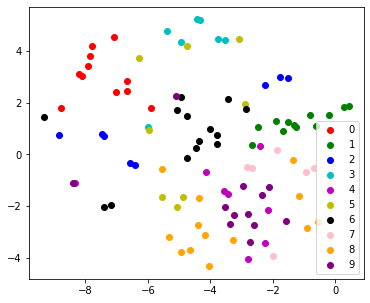

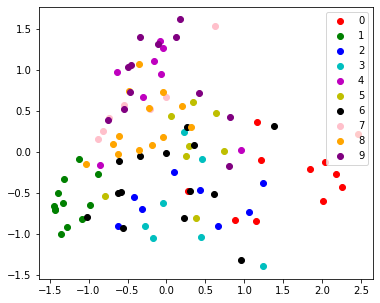

In [45]:
from matplotlib import pyplot as plt
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained[labels_untrained[0:100] == i, 0], X_untrained[labels_untrained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_untrained_PCA[labels_untrained[0:100] == i, 0], X_untrained_PCA[labels_untrained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

# Visualization (Trained)

In [51]:
#tsne_trained2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
copy_trained_data = model_trained.images

pca.fit(copy_trained_data)
X_trained_PCA = pca.transform(copy_trained_data)

x_trained = tsne.fit_transform(copy_trained_data)



[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 8.215596
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.503925
[t-SNE] KL divergence after 800 iterations: 0.359328


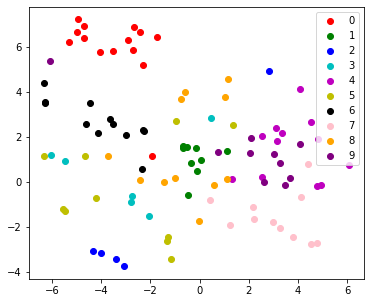

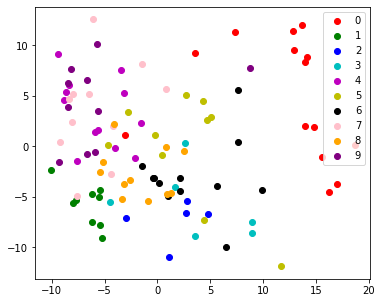

In [52]:
plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(x_trained[labels_trained[0:100] == i, 0], x_trained[labels_trained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,10), colors, numbers):
    plt.scatter(X_trained_PCA[labels_trained[0:100] == i, 0], X_trained_PCA[labels_trained[0:100] == i, 1], c=c, label=label)
plt.legend()
plt.show()

# Accuracy on testset

In [38]:
def test(model, loader):
    true_labels=[]
    pred_labels=[]
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            image, label = data
            pred = model(image)
            for i in range(len(data)):
                if torch.argmax(pred[i]) == label[i]:
                    correct += 1
                total += 1
    print(" predicted = ", correct/total*100, "% of total ",total)
test(model_untrained,testLoader)
test(model_trained,testLoader)

 predicted =  7.784431137724551 % of total  668
 predicted =  98.35329341317365 % of total  668


# Combined visualization of trained/untrained:

![Visualization combined](results.png)